<br>
<font size = 8px> Project 4 bio degradable compounds</font>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Exploratory-Data-Analysis-(EDA)" data-toc-modified-id="Exploratory-Data-Analysis-(EDA)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratory Data Analysis (EDA)</a></span><ul class="toc-item"><li><span><a href="#Results-of-EDA" data-toc-modified-id="Results-of-EDA-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Results of EDA</a></span></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Molecule-Functionality" data-toc-modified-id="Molecule-Functionality-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Molecule Functionality</a></span></li><li><span><a href="#Molecule-Shape" data-toc-modified-id="Molecule-Shape-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Molecule Shape</a></span></li><li><span><a href="#Esther" data-toc-modified-id="Esther-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Esther</a></span></li><li><span><a href="#Summary-Feature-Engineering" data-toc-modified-id="Summary-Feature-Engineering-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Summary Feature Engineering</a></span></li><li><span><a href="#Train_Test_Split" data-toc-modified-id="Train_Test_Split-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Train_Test_Split</a></span></li><li><span><a href="#Transformation" data-toc-modified-id="Transformation-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Transformation</a></span><ul class="toc-item"><li><span><a href="#Poly" data-toc-modified-id="Poly-5.6.1"><span class="toc-item-num">5.6.1&nbsp;&nbsp;</span>Poly</a></span></li><li><span><a href="#Linear" data-toc-modified-id="Linear-5.6.2"><span class="toc-item-num">5.6.2&nbsp;&nbsp;</span>Linear</a></span></li></ul></li></ul></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Basemodel" data-toc-modified-id="Basemodel-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Basemodel</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li></ul></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Linear" data-toc-modified-id="Linear-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Linear</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-7.1.1"><span class="toc-item-num">7.1.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forrest" data-toc-modified-id="Random-Forrest-7.1.2"><span class="toc-item-num">7.1.2&nbsp;&nbsp;</span>Random Forrest</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-7.1.3"><span class="toc-item-num">7.1.3&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Ensemble" data-toc-modified-id="Ensemble-7.1.4"><span class="toc-item-num">7.1.4&nbsp;&nbsp;</span>Ensemble</a></span></li></ul></li><li><span><a href="#Poly" data-toc-modified-id="Poly-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Poly</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forrest" data-toc-modified-id="Random-Forrest-7.2.2"><span class="toc-item-num">7.2.2&nbsp;&nbsp;</span>Random Forrest</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-7.2.3"><span class="toc-item-num">7.2.3&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Ensemble" data-toc-modified-id="Ensemble-7.2.4"><span class="toc-item-num">7.2.4&nbsp;&nbsp;</span>Ensemble</a></span></li></ul></li></ul></li><li><span><a href="#Model-Selection" data-toc-modified-id="Model-Selection-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model Selection</a></span><ul class="toc-item"><li><span><a href="#Result-of-Model-Selection" data-toc-modified-id="Result-of-Model-Selection-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Result of Model Selection</a></span></li></ul></li><li><span><a href="#Model-Optimization" data-toc-modified-id="Model-Optimization-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model Optimization</a></span><ul class="toc-item"><li><span><a href="#Gridsearch" data-toc-modified-id="Gridsearch-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Gridsearch</a></span></li></ul></li><li><span><a href="#Final-Model" data-toc-modified-id="Final-Model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Final Model</a></span><ul class="toc-item"><li><span><a href="#Inspect-final-feature-importance" data-toc-modified-id="Inspect-final-feature-importance-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Inspect final feature importance</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Abstract

The Goal of this project is to use QSAR-Data (Quantitative Structure Ability Relationship) from chemical Compounds and classify biodegradable and non biodegradable substances. Since compounds can last hundreds of years before being decomposed, degradability experiments will take time accordingly. This is where the approach of QSAR begins to shine. Just by looking at relatively quick to obtain molecular properties, the molecules behaviour (in this case biodegradability) can be estimated. Thus helping to ensure correct disposal of chemicals and saving the environment, while also reducing expensive longterm experiments.

In this Project i will:
* use my domain knowledge in chemistry to engineer sophisticated features
* explore multiple classification models
* apply and tune a logistic regression model

Link to Dataset Description : https://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation#

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore') #ignore warning to imporve readability
pd.set_option("display.max_columns", 300) #make every column visible
plt.style.use("ggplot")
%matplotlib inline

In [2]:
#custom functions
from functions import evaluate_classifier #plot confusion matrix and evaluate model using multible test metrics
from functions import plot_coefs #plot coefficients for Regression models

plt.rcParams["figure.figsize"] = [10,5] #setting for correct size of confusion matrix

#Initialize storing for results, in order to easily compare multiple models
results_dict_list = []
results_model_names_list = []

Load and Check Data

In [3]:
!ls #check that all needed files are in the current folder

Data                              README.md
LICENSE                           __pycache__
Pictures                          biodeg.csv
Presentation Biodegradability.pdf functions.py
Project 4 Biodegradables.ipynb    lgR_model_save.pickle


In [4]:
df = pd.read_csv("biodeg.csv", sep = ";", header = None)

In [5]:
df.head() #check columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,0,0.000,3.106,2.550,9.002,0,0.960,1.142,0,0,0,1.201,0,0,0,0,1.932,0.011,0,0.000,4.489,0,0,0,0,2.949,1.591,0,7.253,0,0,RB
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,0,0.000,2.461,1.393,8.723,1,0.989,1.144,0,0,0,1.104,1,0,0,0,2.214,-0.204,0,0.000,1.542,0,0,0,0,3.315,1.967,0,7.257,0,0,RB
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,0,0.000,3.279,2.585,9.110,0,1.009,1.152,0,0,0,1.092,0,0,0,0,1.942,-0.008,0,0.000,4.891,0,0,0,1,3.076,2.417,0,7.601,0,0,RB
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,0,0.000,2.100,0.918,6.594,0,1.108,1.167,0,0,0,1.024,0,0,0,0,1.414,1.073,0,8.361,1.333,0,0,0,1,3.046,5.000,0,6.690,0,0,RB
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,0,-0.271,3.449,2.753,9.528,2,1.004,1.147,0,0,0,1.137,0,0,0,0,1.985,-0.002,0,10.348,5.588,0,0,0,0,3.351,2.405,0,8.003,0,0,RB


The DataFrame is missing column descriptions. These have to be added from the scource website 

Since the columns in the dataset are highly abrriviated, a longer desciption is needed to truly understand the data. The description can originally be obtained here:

https://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation#

For easy sorting functionality and a quick lookup the description is copied from the website and turned into a Pandas DataFrame using the following script:

In [6]:
f = open("Data/description_raw.txt", "r")
description_df = pd.DataFrame(columns = ["short", "description"])
info = "start"
while len(info):
    info = f.readline()
    if not info: 
        break
    info = info.split(") ",1)[1][:-2]
    short = info.split(": ",1)[0]
    #description = info.split(": ",1)[1]
    description_df.loc[len(description_df)] = info.split(": ",1)

The description is saved, to easily share it

In [7]:
#description_df.to_csv("data/description.csv", index=False)
description_df = pd.read_csv("Data/description.csv")

In [8]:
description_df.sort_values("short") #lookup table for Column descriptions

,short,description
23,B01[C-Br],Presence/absence of C - Br at topological dist...
24,B03[C-Cl],Presence/absence of C - Cl at topological dist...
28,B04[C-Br],Presence/absence of C - Br at topological dist...
7,C%,Percentage of C atoms
32,C-026,R--CX--R
3,F01[N-N],Frequency of N-N at topological distance 1
33,F02[C-N],Frequency of C - N at topological distance 2
10,F03[C-N],Frequency of C-N at topological distance 3
15,F03[C-O],Frequency of C - O at topological distance 3
4,F04[C-N],Frequency of C-N at topological distance 4


In [9]:
df.columns = description_df.short #assign describtions to column header

In [10]:
df.head()

short,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,F03[C-N],SdssC,HyWi_B(m),LOC,SM6_L,F03[C-O],Me,Mi,nN-N,nArNO2,nCRX3,SpPosA_B(p),nCIR,B01[C-Br],B03[C-Cl],N-073,SpMax_A,Psi_i_1d,B04[C-Br],SdO,TI2_L,nCrt,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,experimental class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,0,0.000,3.106,2.550,9.002,0,0.960,1.142,0,0,0,1.201,0,0,0,0,1.932,0.011,0,0.000,4.489,0,0,0,0,2.949,1.591,0,7.253,0,0,RB
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,0,0.000,2.461,1.393,8.723,1,0.989,1.144,0,0,0,1.104,1,0,0,0,2.214,-0.204,0,0.000,1.542,0,0,0,0,3.315,1.967,0,7.257,0,0,RB
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,0,0.000,3.279,2.585,9.110,0,1.009,1.152,0,0,0,1.092,0,0,0,0,1.942,-0.008,0,0.000,4.891,0,0,0,1,3.076,2.417,0,7.601,0,0,RB
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,0,0.000,2.100,0.918,6.594,0,1.108,1.167,0,0,0,1.024,0,0,0,0,1.414,1.073,0,8.361,1.333,0,0,0,1,3.046,5.000,0,6.690,0,0,RB
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,0,-0.271,3.449,2.753,9.528,2,1.004,1.147,0,0,0,1.137,0,0,0,0,1.985,-0.002,0,10.348,5.588,0,0,0,0,3.351,2.405,0,8.003,0,0,RB


# Data Cleaning

Now, that the data is loaded and has meaningful headers, further cleaning might be necessary.

In [11]:
#check for Datatypes. Object Types could contain poorly formatted information
df.dtypes.value_counts()

int64      24
float64    17
object      1
dtype: int64

There is only one object column. From a quick look at the DataFrames head the column is our target: `experimental class`. Since this columns is supposed to be formatted as a String, reassigning of Datatypes is not neccessary.

Data still might contain missing values:

In [12]:
df.isnull().sum().sum()

0

No missing values are present.

Some classification models, like logistic regression require the target classes to be expressed as integers. Since degradability ("RB") is the desired positive class it will be encoded as 1, wheres as non degradability will be decoded as 0.

In [13]:
df.replace(["RB","NRB"],[1,0], inplace = True) #apply decoding

In [14]:
#rename target for better readability
df.rename(columns = {"experimental class": "degradable"}, inplace = True);

In [15]:
#save cleaned data
#df.to_csv("Data/biodeg_cleaned.csv", index=False)
#df = pd.read_csv("biodeg_cleaned.csv")

The provided dataset is clean and the target variable properly decoded. 

In [16]:
df.head()

short,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,F03[C-N],SdssC,HyWi_B(m),LOC,SM6_L,F03[C-O],Me,Mi,nN-N,nArNO2,nCRX3,SpPosA_B(p),nCIR,B01[C-Br],B03[C-Cl],N-073,SpMax_A,Psi_i_1d,B04[C-Br],SdO,TI2_L,nCrt,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,degradable
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,0,0.000,3.106,2.550,9.002,0,0.960,1.142,0,0,0,1.201,0,0,0,0,1.932,0.011,0,0.000,4.489,0,0,0,0,2.949,1.591,0,7.253,0,0,1
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,0,0.000,2.461,1.393,8.723,1,0.989,1.144,0,0,0,1.104,1,0,0,0,2.214,-0.204,0,0.000,1.542,0,0,0,0,3.315,1.967,0,7.257,0,0,1
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,0,0.000,3.279,2.585,9.110,0,1.009,1.152,0,0,0,1.092,0,0,0,0,1.942,-0.008,0,0.000,4.891,0,0,0,1,3.076,2.417,0,7.601,0,0,1
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,0,0.000,2.100,0.918,6.594,0,1.108,1.167,0,0,0,1.024,0,0,0,0,1.414,1.073,0,8.361,1.333,0,0,0,1,3.046,5.000,0,6.690,0,0,1
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,0,-0.271,3.449,2.753,9.528,2,1.004,1.147,0,0,0,1.137,0,0,0,0,1.985,-0.002,0,10.348,5.588,0,0,0,0,3.351,2.405,0,8.003,0,0,1


# Exploratory Data Analysis (EDA)

The goal of the following section is to gain insights about the data and to identify columns with great impact on the target classes.

In [17]:
df.describe()

short,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,F03[C-N],SdssC,HyWi_B(m),LOC,SM6_L,F03[C-O],Me,Mi,nN-N,nArNO2,nCRX3,SpPosA_B(p),nCIR,B01[C-Br],B03[C-Cl],N-073,SpMax_A,Psi_i_1d,B04[C-Br],SdO,TI2_L,nCrt,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,degradable
count,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000
mean,4.782644,3.069508,0.716588,0.042654,0.980095,0.290047,1.646445,37.055640,1.376303,1.803791,1.436967,-0.197129,3.476844,1.350716,9.937381,3.630332,1.013302,1.131106,0.008531,0.073934,0.029384,1.238727,1.405687,0.039810,0.147867,0.031280,2.215641,-0.001206,0.026540,8.780510,2.668344,0.129858,0.883412,1.274882,0.961137,3.918240,2.558417,0.686256,8.629492,0.051185,0.723223,0.337441
std,0.546916,0.831308,1.462452,0.256010,2.332955,1.073771,2.224822,9.144466,1.963521,1.775435,3.116577,0.769662,0.584150,0.786166,0.928678,4.457243,0.046494,0.030143,0.101802,0.317475,0.217997,0.096466,4.788542,0.195606,0.355137,0.199544,0.226131,0.158928,0.160812,11.895889,2.096607,0.644057,1.520467,2.273994,1.257013,0.999602,0.642765,1.090389,1.241986,0.318970,2.239286,0.473061
min,2.000000,0.803900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.256000,1.544000,0.000000,4.174000,0.000000,0.957000,1.022000,0.000000,0.000000,0.000000,0.863000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.099000,0.000000,0.000000,0.444000,0.000000,0.000000,0.000000,0.000000,2.267000,1.467000,0.000000,4.917000,0.000000,0.000000,0.000000
25%,4.481000,2.502750,0.000000,0.000000,0.000000,0.000000,0.000000,30.450000,0.000000,0.000000,0.000000,-0.191000,3.105000,0.875000,9.533000,0.000000,0.983000,1.116000,0.000000,0.000000,0.000000,1.182000,0.000000,0.000000,0.000000,0.000000,2.101000,-0.008000,0.000000,0.000000,1.446500,0.000000,0.000000,0.000000,0.000000,3.487500,2.103000,0.000000,7.991000,0.000000,0.000000,0.000000
50%,4.828000,3.046300,0.000000,0.000000,0.000000,0.000000,1.000000,37.500000,1.000000,2.000000,0.000000,0.000000,3.442000,1.187000,10.039000,2.000000,1.003000,1.130000,0.000000,0.000000,0.000000,1.243000,1.000000,0.000000,0.000000,0.000000,2.247000,0.000000,0.000000,0.000000,2.052000,0.000000,0.000000,0.000000,1.000000,3.726000,2.458000,0.000000,8.499000,0.000000,0.000000,0.000000
75%,5.125000,3.437650,1.000000,0.000000,1.000000,0.000000,3.000000,43.400000,2.000000,3.000000,2.000000,0.000000,3.825500,1.705000,10.514500,6.000000,1.029000,1.143000,0.000000,0.000000,0.000000,1.296000,2.000000,0.000000,0.000000,0.000000,2.358000,0.005000,0.000000,12.465000,3.146000,0.000000,1.000000,2.000000,2.000000,3.987000,2.870500,1.000000,9.020500,0.000000,0.000000,1.000000
max,6.496000,9.177500,12.000000,3.000000,36.000000,13.000000,18.000000,60.700000,24.000000,12.000000,44.000000,4.722000,5.701000,4.491000,12.609000,40.000000,1.311000,1.377000,2.000000,3.000000,3.000000,1.641000,147.000000,1.000000,1.000000,3.000000,2.859000,1.073000,1.000000,71.167000,17.537000,8.000000,12.000000,18.000000,7.000000,10.695000,5.825000,8.000000,14.700000,4.000000,27.000000,1.000000


The desciption of the DataFrame implies, that there are a lot of zero values. Hence the number of zeros for each column will be investigated.

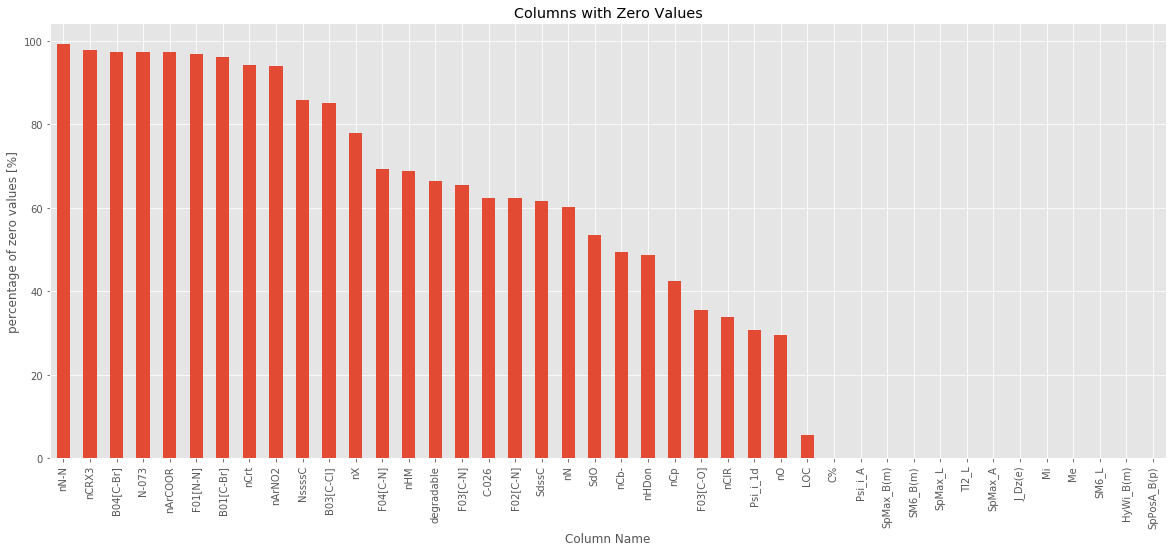

In [18]:
#check data for zero values
zeros = [round(sum(df.iloc[:,i] == 0)/len(df),3)*100 for i in range(df.shape[1])]
zero = pd.DataFrame(zeros , index = df.columns).sort_values(by=0, ascending = False)

#plot results
zero.plot(kind = "bar", legend = False, figsize =(20,8))
plt.title("Columns with Zero Values")
plt.ylabel("percentage of zero values [%]")
plt.xlabel("Column Name");

TODO: why are zeros not common for some variables??


While zero values in a lot of columns are quite common, it does not provide any evidence of missing data. Since the actual molecule names or structures are not provided, zero values will be kept. This accounts for the QSAR data checks for molecule properties like N-N-Azzo groups, that are fairly rare and therefore often result in a zero value.
The zero values in the `degradable`column shows, that the distribution of the target is around 60 % non degradable.

The exact Value for the ditribution of the target classes is:

In [19]:
df["degradable"].value_counts(normalize = True)
# NRB = 0 --> Not Biodegradable
# RB = 1 --> Biodegradable

0    0.662559
1    0.337441
Name: degradable, dtype: float64

The numbers show that there is a slight class inbalance. Class inbalance will lead to a bias towards the majority class, if the inbalance is too high. In this case, the inbalance is quite small. I decided to keep the inbalance since upscaling would lead to duplicates and downscaling to a loss of data. I considere both scenarios to have a worse impact on model performance then the bias from the class inbalance.

In the next step multicolinearity is checked. This becomes a problem when running Regression models. Thus, highly cocorrelated features (|r| > 0.90) will be dropped. When deciding which of two correlated features to keep, the one with the higher correlation to the traget and therefore higher prediction value will be keept.

In [20]:
#check for correlation with target 
#abs(df.corr()["degradable"]).sort_values(ascending = False).head(11)

In [21]:
#get critical correlation values
df.corr().applymap(lambda x: x if abs(x)>.90 else "")

short,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,F03[C-N],SdssC,HyWi_B(m),LOC,SM6_L,F03[C-O],Me,Mi,nN-N,nArNO2,nCRX3,SpPosA_B(p),nCIR,B01[C-Br],B03[C-Cl],N-073,SpMax_A,Psi_i_1d,B04[C-Br],SdO,TI2_L,nCrt,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,degradable
short,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SpMax_L,1,,,,,,,,,,,,,,0.911546,,,,,,,,,,,,0.918928,,,,,,,,,,,,,,,
J_Dz(e),,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nHM,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F01[N-N],,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F04[C-N],,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NssssC,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nCb-,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C%,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nCp,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


The above figure shows that cocorrelations are present. Therefore the following columns will be dropped:

In [22]:
corr_drop = ["SM6_L","SpMax_A","SM6_B(m)"]
corr_keep = list(set(df.columns)-set(corr_drop))

In the next step the remaining features will be how good these features are able to divide the degradable and nondegradable substances. There the set is split into the target classes and then each each calss is plotted side by side for each feature.

In [23]:
# split data into degradable and nondegradable subsets
bio_df = df.loc[df["degradable"] == 1]
no_bio_df = df.loc[df["degradable"] == 0]

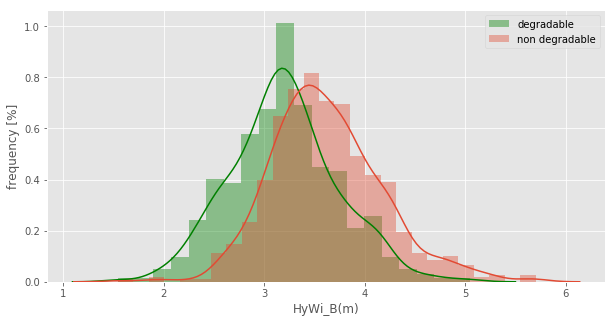

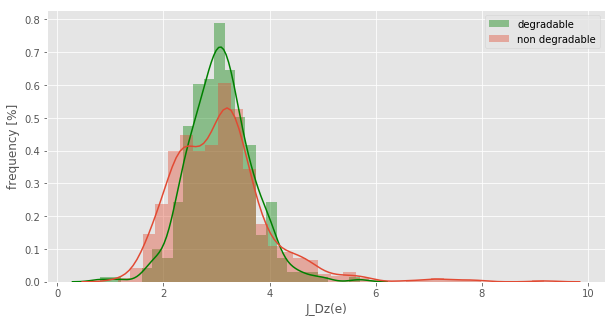

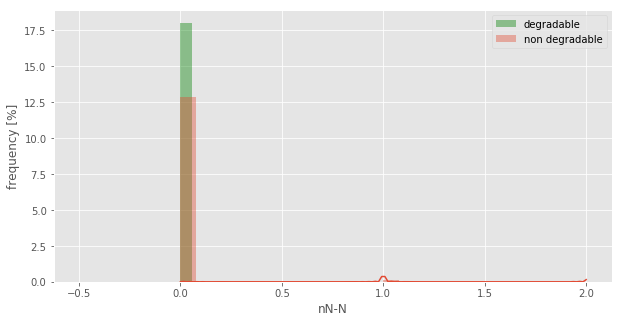

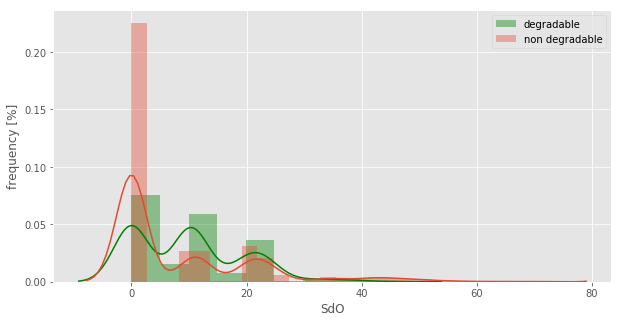

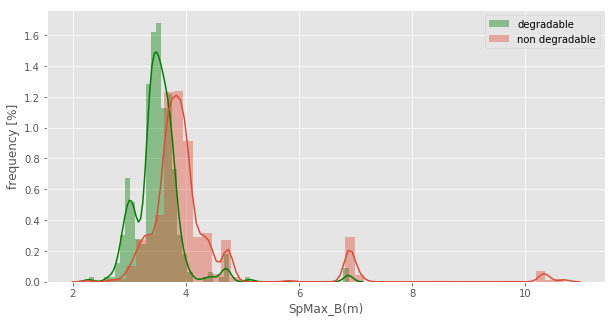

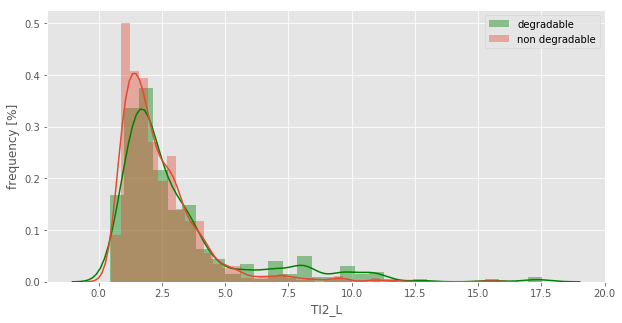

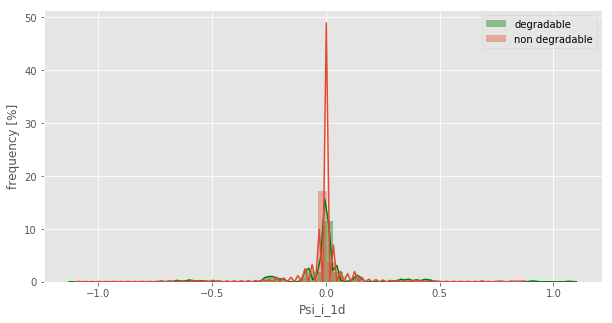

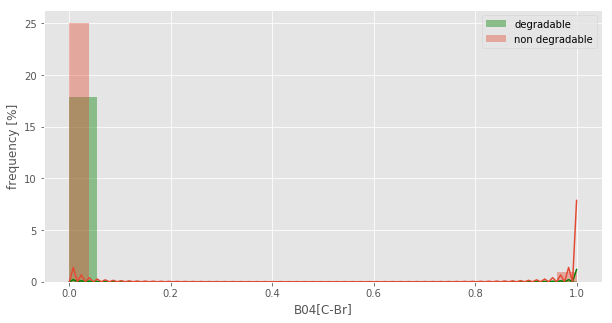

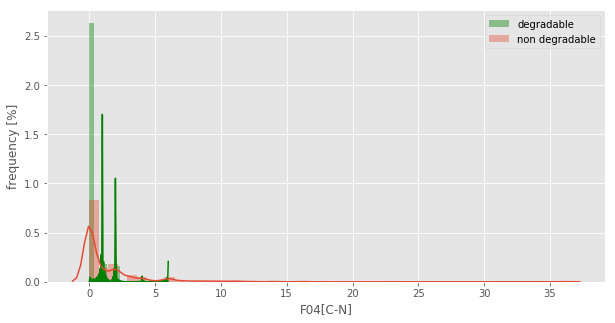

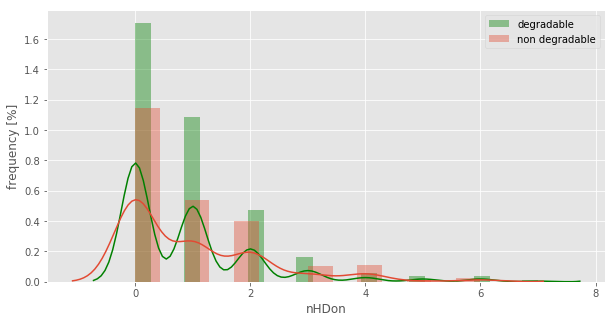

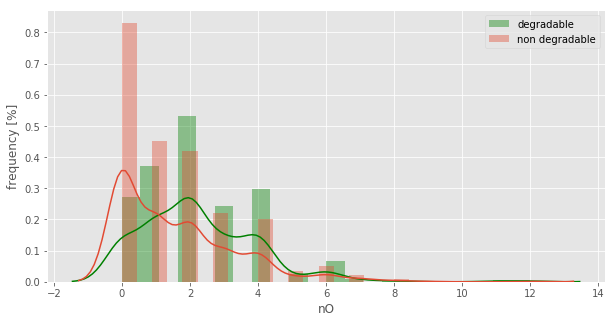

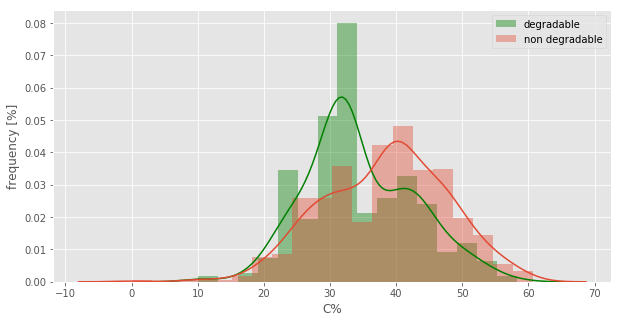

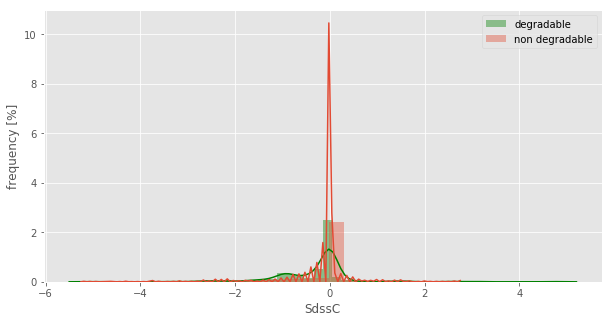

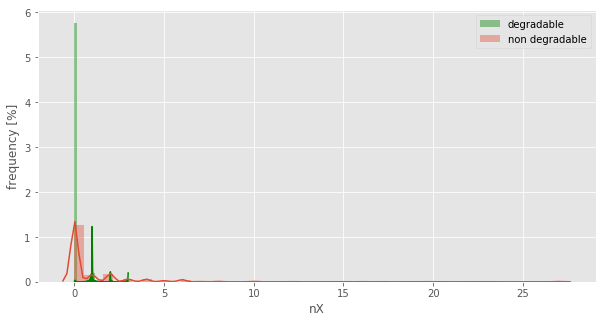

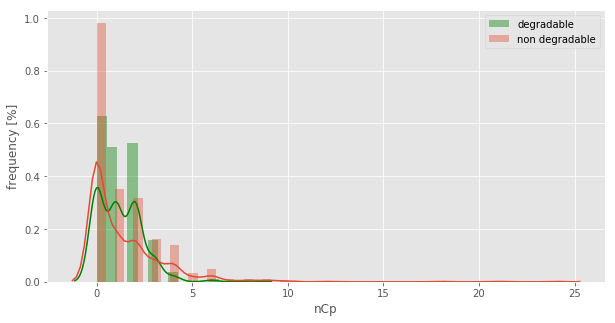

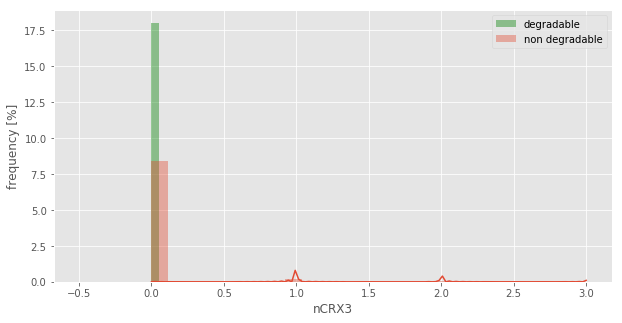

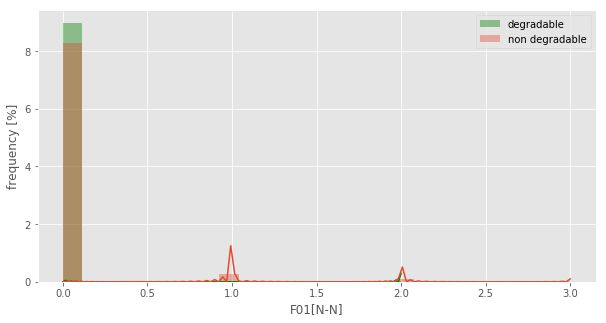

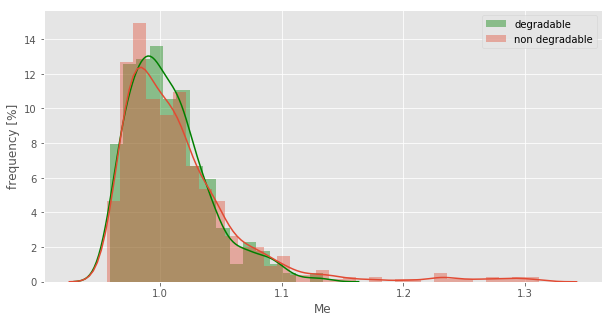

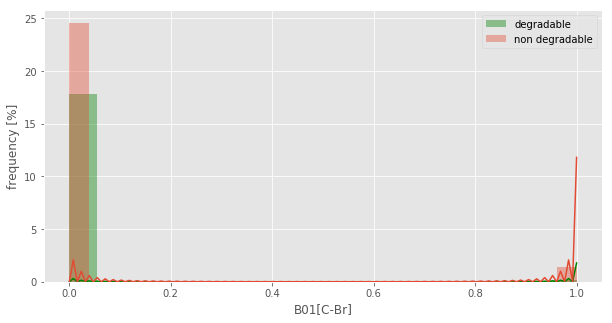

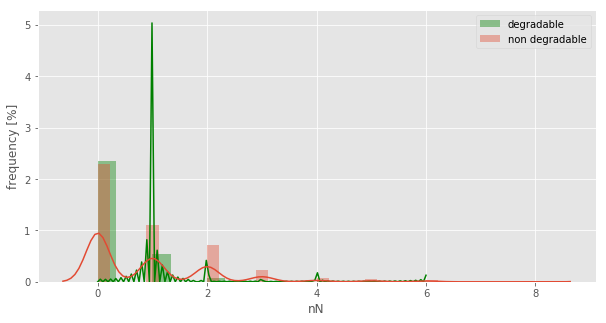

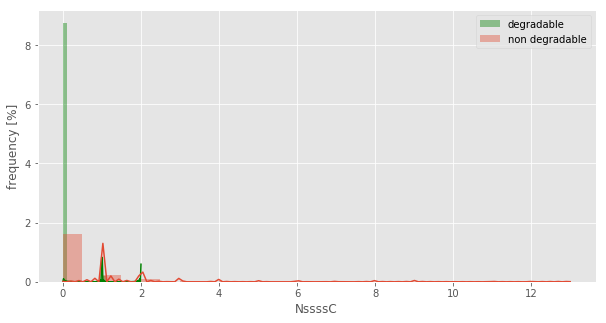

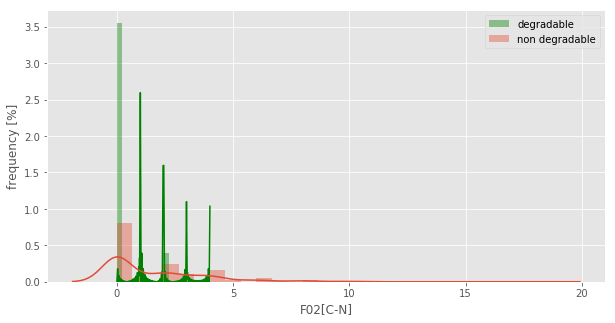

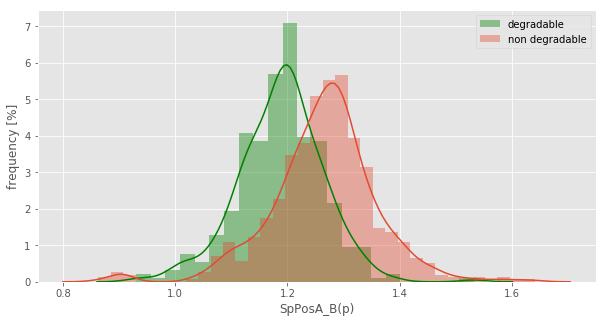

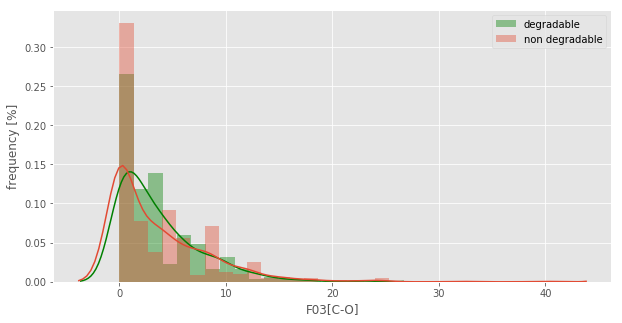

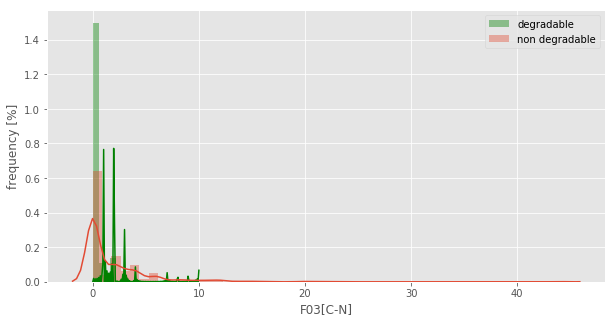

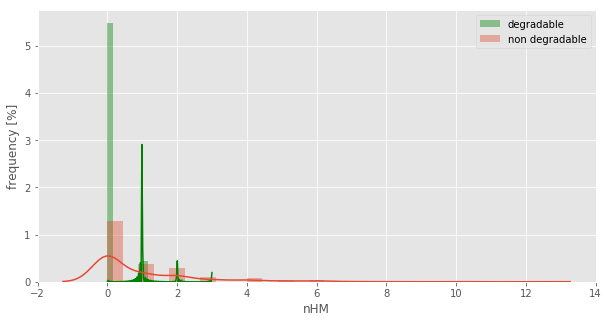

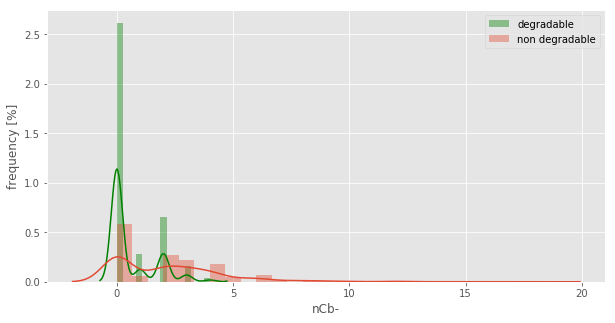

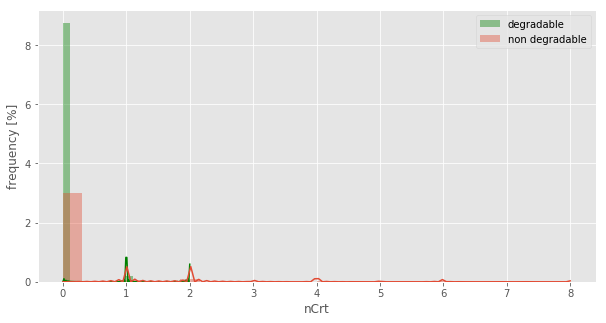

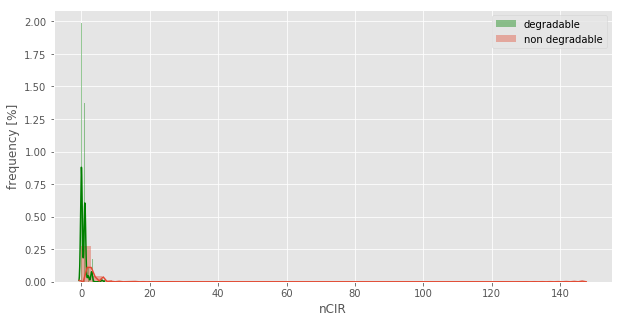

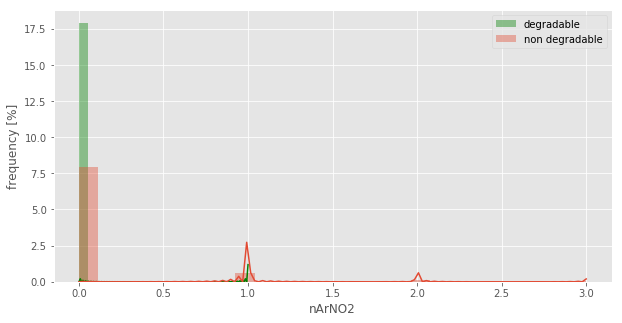

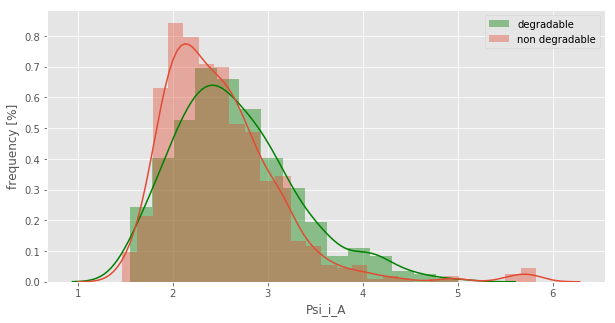

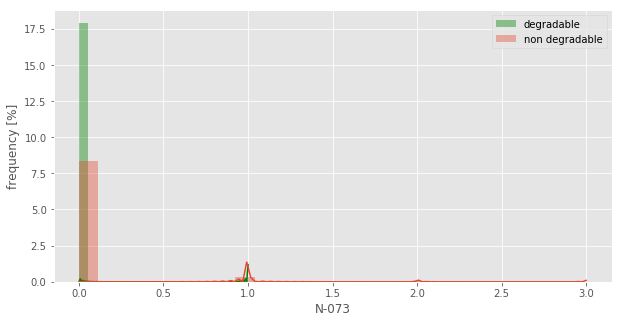

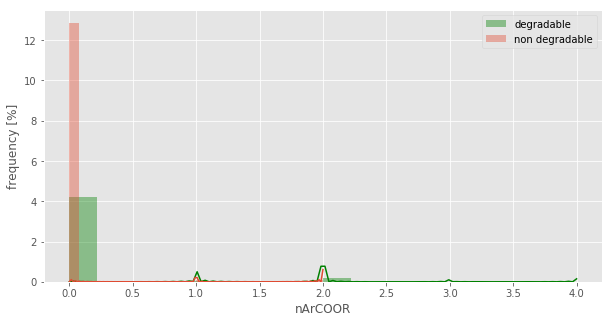

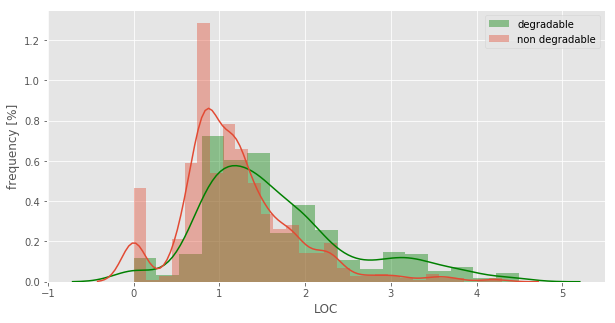

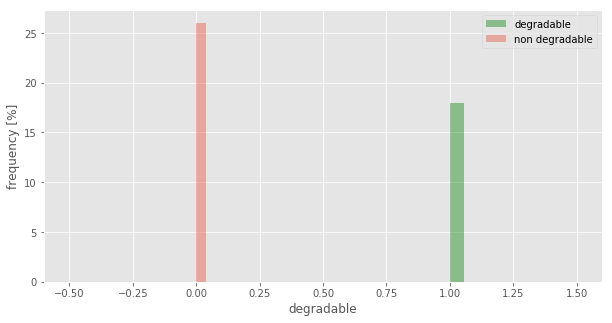

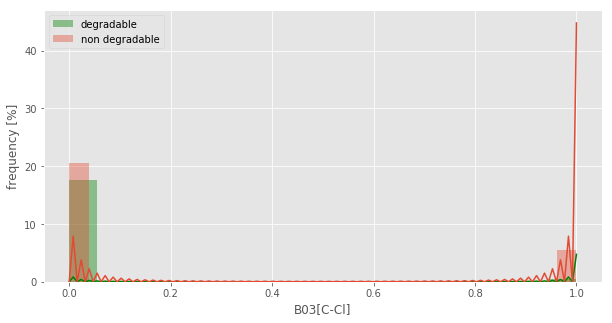

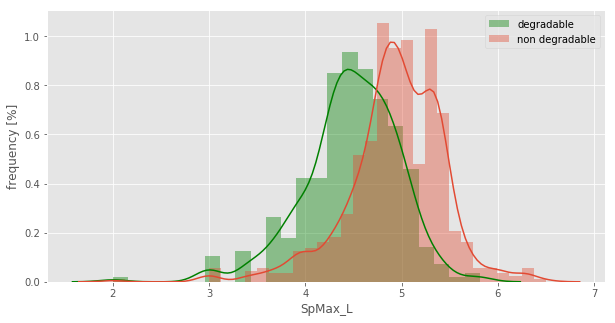

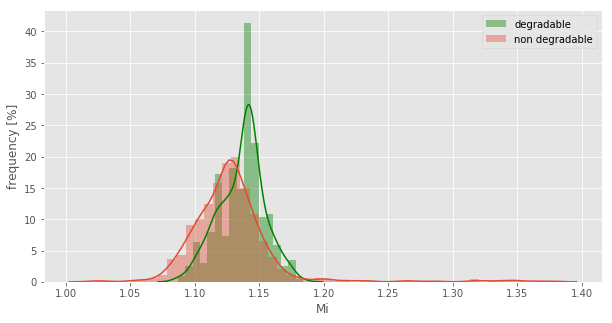

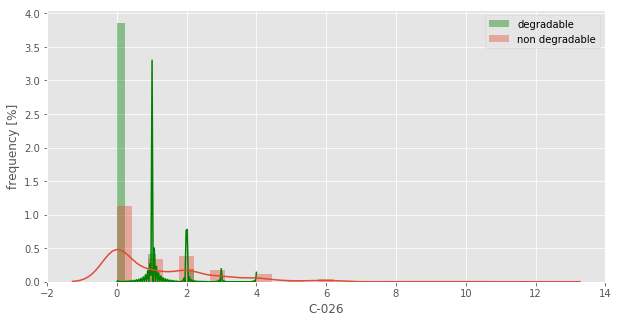

In [24]:
features = corr_keep #only use the features that are not cocorrelated

#plot the features side by side
for col in list(filter(lambda x: x != "diagnosis", features)):
    sns.distplot(bio_df[col] ,label = "degradable", color = "g")
    sns.distplot(no_bio_df[col], label = "non degradable" )
    plt.ylabel("frequency [%]")
    plt.legend()
    plt.show()

The distribution show that the best prediciting features for class seperation are:
+ SpPosA_B(p)
+ HyWi_B(m)
+ C%
+ SpMax_B(m)
+ SpMax_L

The above plots also shows, that many features contain just a few different values. These are most liekely to be discrete values and must be investigated further.

In [25]:
#If a feature has more then 10 unique values it is probably not categorical, but continuous.
features = corr_keep

#initialize storing variables
continous = []
discrete = []

#check for features less then 10 different values
for col in features:
    valc = df[col].value_counts(normalize = True)
    if len(valc)<10:
        print(col)
        print(valc)
        print("--------------")
        discrete.append(col)
    else:
        continous.append(col)

nN-N
0    0.992417
1    0.006635
2    0.000948
Name: nN-N, dtype: float64
--------------
B04[C-Br]
0    0.97346
1    0.02654
Name: B04[C-Br], dtype: float64
--------------
nHDon
0    0.486256
1    0.254976
2    0.158294
3    0.044550
4    0.036967
6    0.011374
5    0.006635
7    0.000948
Name: nHDon, dtype: float64
--------------
nCRX3
0    0.979147
1    0.013270
2    0.006635
3    0.000948
Name: nCRX3, dtype: float64
--------------
F01[N-N]
0    0.968720
1    0.020853
2    0.009479
3    0.000948
Name: F01[N-N], dtype: float64
--------------
B01[C-Br]
0    0.96019
1    0.03981
Name: B01[C-Br], dtype: float64
--------------
nN
0    0.600948
1    0.224645
2    0.111848
3    0.036019
4    0.012322
6    0.006635
5    0.006635
8    0.000948
Name: nN, dtype: float64
--------------
nCrt
0    0.942180
1    0.022749
2    0.020853
4    0.007583
6    0.002844
3    0.001896
8    0.000948
5    0.000948
Name: nCrt, dtype: float64
--------------
nArNO2
0    0.940284
1    0.047393
2    0.010427
3    

The output shows, that several columns are in fact discrete. Moreover, the most common value in these features is zero. Again, showing some rare molecule properties. Most of them containing information about special "functional" groups in the molecule that usually have a large impact on the molecules properties and chemical behaviour.

## Results of EDA

* The following Features lead to a high speration of the target classes. 
    + SpPosA_B(p)
    + HyWi_B(m)
    + C%
    + SpMax_B(m)
    + SpMax_L

* Discrete features provide evidence for molecular classification according to special functional groups.
* The majority of features has rare occurances in the dataset

# Feature Engineering

In the following section, the findings from the EDA are combined with my chemical backround knowledge to create new features that help dividing the target classes.

## Molecule Functionality
This feature will be recoded to inform about heavy Metal atoms:
+ It is most likely that in degradable organic compounds there is only one heavy metal atom present (nHM =1) in as a single central atom in a chemical complex bound.
+ If nHM exeeds one a compound will be either anorganic or of high toxicity and therefore lead to low biodegradability. (nHM >1)

In [26]:
#define function for encoding the number of Heavy Metal Atoms
def encode_nHM(x):
    if x == 0:
        return "light"
    if x == 1:
        return "functional"
    if x >1:
        return "heavy"

In [27]:
#apply Function for feature Engineering
df["nHM_enc"] = df["nHM"].apply(encode_nHM)

Grouping shows that there is in fact a certain seperation of target classes in using this feature.

In [28]:
df.groupby(["nHM_enc","degradable"]).count()

short                  SpMax_L  J_Dz(e)  nHM  F01[N-N]  F04[C-N]  NssssC  \
nHM_enc    degradable                                                      
functional 0               116      116  116       116       116     116   
           1                26       26   26        26        26      26   
heavy      0               181      181  181       181       181     181   
           1                 5        5    5         5         5       5   
light      0               402      402  402       402       402     402   
           1               325      325  325       325       325     325   

short                  nCb-   C%  nCp   nO  F03[C-N]  SdssC  HyWi_B(m)  LOC  \
nHM_enc    degradable                                                         
functional 0            116  116  116  116       116    116        116  116   
           1             26   26   26   26        26     26         26   26   
heavy      0            181  181  181  181       181    181        181  181   
           1              5    5    5    5         5      5          5    5   
light      0            402  402  402  402       402    402        402  402   
           1            325  325  325  325       325    325        325  325   

short                  SM6_L  F03[C-O]   Me   Mi  nN-N  nArNO2  nCRX3  \
nHM_enc    degradable                                                   
functional 0             116       116  116  116   116     116    116   
           1              26        26   26   26    26      26     26   
heavy      0             181       181  181  181   181     181    181   
           1               5         5    5    5     5       5      5   
light      0             402       402  402  402   402     402    402   
           1             325       325  325  325   325     325    325   

short                  SpPosA_B(p)  nCIR  B01[C-Br]  B03[C-Cl]  N-073  \
nHM_enc    degradable                                                   
functional 0                   116   116        116        116    116   
           1                    26    26         26         26     26   
heavy      0                   181   181        181        181    181   
           1                     5     5          5          5      5   
light      0                   402   402        402        402    402   
           1                   325   325        325        325    325   

short                  SpMax_A  Psi_i_1d  B04[C-Br]  SdO  TI2_L  nCrt  C-026  \
nHM_enc    degradable                                                          
functional 0               116       116        116  116    116   116    116   
           1                26        26         26   26     26    26     26   
heavy      0               181       181        181  181    181   181    181   
           1                 5         5          5    5      5     5      5   
light      0               402       402        402  402    402   402    402   
           1               325       325        325  325    325   325    325   

short                  F02[C-N]  nHDon  SpMax_B(m)  Psi_i_A   nN  SM6_B(m)  \
nHM_enc    degradable                                                        
functional 0                116    116         116      116  116       116   
           1                 26     26          26       26   26        26   
heavy      0                181    181         181      181  181       181   
           1                  5      5           5        5    5         5   
light      0                402    402         402      402  402       402   
           1                325    325         325      325  325       325   

short                  nArCOOR   nX  
nHM_enc    degradable                
functional 0               116  116  
           1                26   26  
heavy      0               181  181  
           1                 5    5  
light      0               402  402  
           1               325  325

Since the Variable is categorical, it must be one-hot encoded (turned into dummy variables) to be properly interpreted while modeling.

In [29]:
nHM_dummies = pd.get_dummies(df["nHM_enc"],"nHM").drop("nHM_light",axis = 1)
df = pd.concat([df,nHM_dummies], axis = 1).drop("nHM_enc", axis = 1)

## Molecule Shape
The number of terminal C-Atoms informs about the overall shape of a molecule, highly branched meolecules are expected to be less degradable, because the branches make it harder for enzymes to connect to the molecule and deconstruct it.

In [30]:
#define function for encoding the number of terminal C-Atoms to infer molecule shape
def shape_class(x):
    if x == 0:
        return "ring"
    if x == 1:
        return "semi_ring"
    if x == 2:
        return "linear"
    if x >2:
        return "branched"

In [31]:
#apply function for feature engineering
df["molShape"] = df["nCp"].apply(shape_class)

Grouping shows that espeacially branched and ring shaped molecules provide a good seperation between target classes.

In [32]:
df.groupby(["molShape","degradable"]).count()

SpMax_L  J_Dz(e)  nHM  F01[N-N]  F04[C-N]  NssssC  nCb-  \
molShape  degradable                                                            
branched  0               145      145  145       145       145     145   145   
          1                40       40   40        40        40      40    40   
linear    0               107      107  107       107       107     107   107   
          1               100      100  100       100       100     100   100   
ring      0               329      329  329       329       329     329   329   
          1               119      119  119       119       119     119   119   
semi_ring 0               118      118  118       118       118     118   118   
          1                97       97   97        97        97      97    97   

                       C%  nCp   nO  F03[C-N]  SdssC  HyWi_B(m)  LOC  SM6_L  \
molShape  degradable                                                          
branched  0           145  145  145       145    145        145  145    145   
          1            40   40   40        40     40         40   40     40   
linear    0           107  107  107       107    107        107  107    107   
          1           100  100  100       100    100        100  100    100   
ring      0           329  329  329       329    329        329  329    329   
          1           119  119  119       119    119        119  119    119   
semi_ring 0           118  118  118       118    118        118  118    118   
          1            97   97   97        97     97         97   97     97   

                      F03[C-O]   Me   Mi  nN-N  nArNO2  nCRX3  SpPosA_B(p)  \
molShape  degradable                                                         
branched  0                145  145  145   145     145    145          145   
          1                 40   40   40    40      40     40           40   
linear    0                107  107  107   107     107    107          107   
          1                100  100  100   100     100    100          100   
ring      0                329  329  329   329     329    329          329   
          1                119  119  119   119     119    119          119   
semi_ring 0                118  118  118   118     118    118          118   
          1                 97   97   97    97      97     97           97   

                      nCIR  B01[C-Br]  B03[C-Cl]  N-073  SpMax_A  Psi_i_1d  \
molShape  degradable                                                         
branched  0            145        145        145    145      145       145   
          1             40         40         40     40       40        40   
linear    0            107        107        107    107      107       107   
          1            100        100        100    100      100       100   
ring      0            329        329        329    329      329       329   
          1            119        119        119    119      119       119   
semi_ring 0            118        118        118    118      118       118   
          1             97         97         97     97       97        97   

                      B04[C-Br]  SdO  TI2_L  nCrt  C-026  F02[C-N]  nHDon  \
molShape  degradable                                                        
branched  0                 145  145    145   145    145       145    145   
          1                  40   40     40    40     40        40     40   
linear    0                 107  107    107   107    107       107    107   
          1                 100  100    100   100    100       100    100   
ring      0                 329  329    329   329    329       329    329   
          1                 119  119    119   119    119       119    119   
semi_ring 0                 118  118    118   118    118       118    118   
          1                  97   97     97    97     97        97     97   

                      SpMax_B(m)  Psi_i_A   nN  SM6_B(m)  nArCOOR   nX  \
molShape  deg

The feature is one-hot encoded to be used for subsequent modeling.

In [33]:
mS_dummies = pd.get_dummies(df["molShape"],"mS").drop("mS_semi_ring",axis = 1)
df = pd.concat([df,mS_dummies], axis = 1).drop("molShape",axis = 1)

## Esther
Esther groups provide an easy breaking point due to hydrolysis (breaking down a molecule using water and enzymes, a common method used by microbes). Thus degradability for Esters is therefore high.

In [34]:
df["esther"] = df.nArCOOR.apply(lambda x: 1 if x>0 else x)

Grouping shows s seperation but the data lacks observations with molecule containing an esther groups. Therefore the effect of this feature will be hardly recognisable

In [35]:
df.groupby(["esther","degradable"]).count()

SpMax_L  J_Dz(e)  nHM  F01[N-N]  F04[C-N]  NssssC  nCb-  \
esther degradable                                                            
0      0               691      691  691       691       691     691   691   
       1               334      334  334       334       334     334   334   
1      0                 8        8    8         8         8       8     8   
       1                22       22   22        22        22      22    22   

                    C%  nCp   nO  F03[C-N]  SdssC  HyWi_B(m)  LOC  SM6_L  \
esther degradable                                                          
0      0           691  691  691       691    691        691  691    691   
       1           334  334  334       334    334        334  334    334   
1      0             8    8    8         8      8          8    8      8   
       1            22   22   22        22     22         22   22     22   

                   F03[C-O]   Me   Mi  nN-N  nArNO2  nCRX3  SpPosA_B(p)  nCIR  \
esther degradable                                                               
0      0                691  691  691   691     691    691          691   691   
       1                334  334  334   334     334    334          334   334   
1      0                  8    8    8     8       8      8            8     8   
       1                 22   22   22    22      22     22           22    22   

                   B01[C-Br]  B03[C-Cl]  N-073  SpMax_A  Psi_i_1d  B04[C-Br]  \
esther degradable                                                              
0      0                 691        691    691      691       691        691   
       1                 334        334    334      334       334        334   
1      0                   8          8      8        8         8          8   
       1                  22         22     22       22        22         22   

                   SdO  TI2_L  nCrt  C-026  F02[C-N]  nHDon  SpMax_B(m)  \
esther degradable                                                         
0      0           691    691   691    691       691    691         691   
       1           334    334   334    334       334    334         334   
1      0             8      8     8      8         8      8           8   
       1            22     22    22     22        22     22          22   

                   Psi_i_A   nN  SM6_B(m)  nArCOOR   nX  nHM_functional  \
esther degradable                                                         
0      0               691  691       691      691  691             691   
       1               334  334       334      334  334             334   
1      0                 8    8         8        8    8               8   
       1                22   22        22       22   22              22   

                   nHM_heavy  mS_branched  mS_linear  mS_ring  
esther degradable                                              
0      0                 691          691        691      691  
       1                 334          334        334      334  
1      0                   8            8          8        8  
       1                  22           22         22       22

Save/Load engineered DataFrame

In [36]:
#df.to_csv("Data/df_engineered.csv", index=False)
#df = pd.read_csv("Data/df_engineered.csv")

## Summary Feature Engineering

Three Feautures where Engineered:
+ Molecule Functionality
+ Molecule Shape
+ Molecule is Esther (and therefore provieds a good breaking point)

Molecule functionality and shape provide a good sepreation in the target classes.

## Train_Test_Split

In order to test and validate the models, a train test split is performed.

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
#remove colinear columns as identified in EDA
keep = list(set(df.columns) - set(corr_drop))

Define Target and Feature Variables and perform standard 80/20 split. Then check for the right dimensions of the resulting DataFrames

In [39]:
y = df.degradable
X = df[keep].drop("degradable", axis = 1)
X_train, X_test, y_train , y_test = train_test_split(X,y ,random_state=42 , test_size = 0.3)

In [40]:
X_train.shape, X_test.shape

((738, 44), (317, 44))

In [41]:
y_train.shape , y_test.shape

((738,), (317,))

## Transformation

In order to further prepare the data for the modeling process, the data will be standardized. This is espeacially important when unsing distance based models such as KNN.

In [42]:
from sklearn.preprocessing import StandardScaler

### Poly

Further Features will be engineered using polynomial interaction terms, starting with a polynomial degree of two. If polynomial features provide a good predictability during the modeling process, further polynomial degrees might be investigated.

Generate Interaction Terms using polynomials.

In [43]:
from sklearn.preprocessing import PolynomialFeatures

In [44]:
poly = PolynomialFeatures(2,include_bias = False)
poly.fit(X_train)
X_train_poly = (pd.DataFrame(poly.transform(X_train),columns = poly.get_feature_names(X_train.columns)))
X_test_poly = (pd.DataFrame(poly.transform(X_test),columns = poly.get_feature_names(X_train.columns)))

Scale features to improve model performance and store polynomial Train and Test sets for later use.

In [45]:
scaler_poly = StandardScaler()
scaler_poly.fit(X_train_poly)
X_train_poly = pd.DataFrame(scaler_poly.transform(X_train_poly),columns = X_train_poly.columns)
X_test_poly = pd.DataFrame(scaler_poly.transform(X_test_poly),columns = X_train_poly.columns)

### Linear

The linear features are processed after the polynomial features, so that the scaled train and test sets can be used immediatly.

Scale Features to improve Model performance

In [46]:
scaler_lin = StandardScaler()
scaler_lin.fit(X_train)
X_train = pd.DataFrame(scaler_lin.transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(scaler_lin.transform(X_test),columns = X_train.columns)

In [47]:
lin_cols_all = X_train.columns # store linear column names

#Store processed Sets as csv to quickly recover them if needed
#X_train.to_csv("Data/X_train_lin_scaled.csv", index=False)
#X_test.to_csv("Data/X_test_lin_scaled.csv", index=False)

# Feature Selection

The goal of this section is to narrow down the ammount of features used in a model.
Only features with high predictability for the target are kept.

Feature Selection will be performed using Lasso Penalty in a Logistic Regression Classifier Model.
The target metrics are:
+ Precission (because predicting biodegradability when the molecule is not (false positive) is worse than predicting nondegradability allthough the molecule is degradable.
+ Specificity (to compare model performance with values in the scource paper)
+ Sensitivity (to compare Model performance with values in the scource paper)
+ F1 (to get an overall scoring)

Features are dropped, if their removal does not significantly lower model performance.

In [48]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

## Basemodel

The basemodel is produced to provide a scoring on which differences in performance due to alteration in the modeltype or the selected features can be measured. I chose a LogisticRegression model, because:
+ Results have a moderatly high interpretability
+ Features can be ranked by their importance
+ The lasso restriction method for feature selection can be performed easily

### Logistic Regression

Normalized confusion matrix
[[0.89952153 0.10047847]
 [0.13888889 0.86111111]]


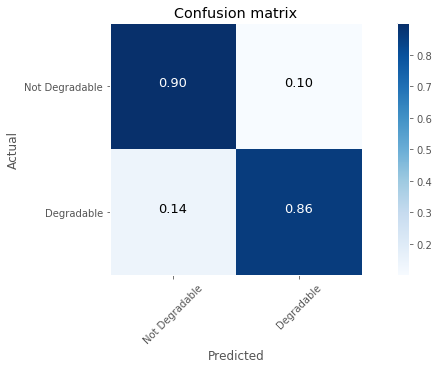

Our Accuracy is: 0.886435331230284
Our Precision is: 0.8157894736842105
Our Sensitivity is: 0.8611111111111112
Our F-Score is: 0.8378378378378377


In [49]:
#instantiate and fit model on the training set and then run a prediction on the test set
logReg_base = LogisticRegression(random_state=42)
logReg_base.fit(X_train,y_train)
logReg_base_pred = logReg_base.predict(X_test)

#save results for model selection
results_dict_list.append(evaluate_classifier(y_test,logReg_base_pred, normalize=True))
results_model_names_list.append("LogR_base")

<Figure size 1152x1080 with 0 Axes>

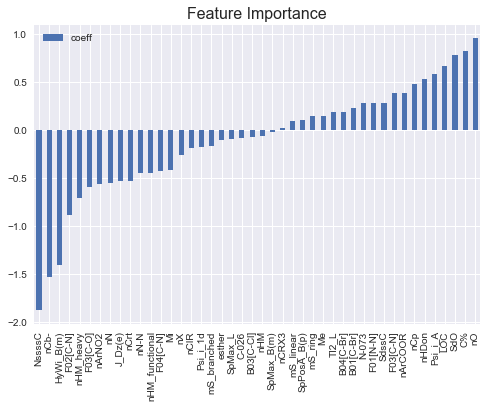

Index([], dtype='object')

In [50]:
#plot feature importance
plot_coefs(X_train,logReg_base)

The evaluation metrics show, that the baseline model already performes quite well.

# Modeling

In the following sections multiple types of classification models are testes for their performance. For each model the following steps are performed:
1. instantiate model
2. fit model to training set
3. predict and evaluate on test set
4. select least important features to drop
5. store results for model selection

## Linear

### Logistic Regression

Normalized confusion matrix
[[0.89473684 0.10526316]
 [0.13888889 0.86111111]]


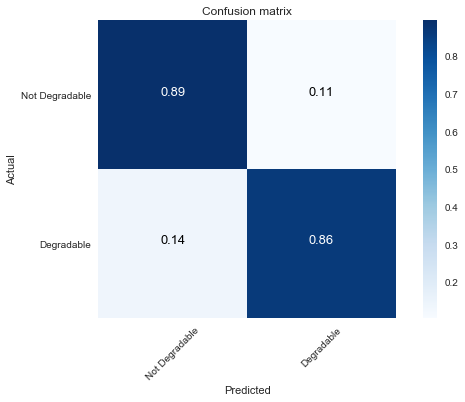

Our Accuracy is: 0.8832807570977917
Our Precision is: 0.808695652173913
Our Sensitivity is: 0.8611111111111112
Our F-Score is: 0.8340807174887893


<Figure size 1152x1080 with 0 Axes>

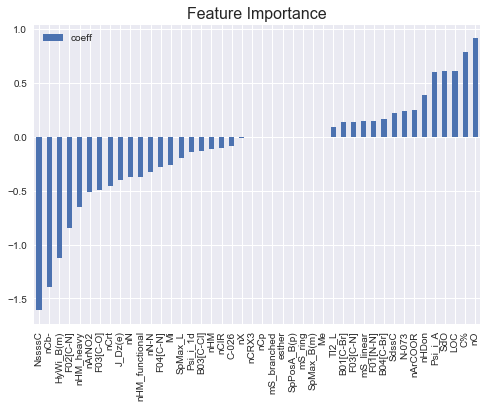

In [51]:
logReg_base_l1 = LogisticRegression(solver = "saga", penalty = "l1", C = 0.7, random_state=42)
logReg_base_l1.fit(X_train,y_train)
logReg_base_l1_pred = logReg_base_l1.predict(X_test)

results_dict_list.append(evaluate_classifier(y_test,logReg_base_l1_pred, normalize=True))
results_model_names_list.append("LogR_lin_l1")

#select features with a coefician of zero to be dropped
drop_l1 = plot_coefs(X_train,logReg_base_l1)

In [52]:
# keep all the features from the above figure, that dont have a coefficent of zero
l1_keep = list(set(X_train.columns) - set(drop_l1))
l1_keep

['HyWi_B(m)',
 'J_Dz(e)',
 'nN-N',
 'SdO',
 'TI2_L',
 'Psi_i_1d',
 'B04[C-Br]',
 'F04[C-N]',
 'nHDon',
 'nO',
 'C%',
 'SdssC',
 'nX',
 'F01[N-N]',
 'B01[C-Br]',
 'nN',
 'NssssC',
 'nHM_heavy',
 'F02[C-N]',
 'F03[C-O]',
 'mS_linear',
 'F03[C-N]',
 'nHM',
 'nCb-',
 'nCrt',
 'nCIR',
 'nArNO2',
 'Psi_i_A',
 'N-073',
 'nArCOOR',
 'LOC',
 'nHM_functional',
 'B03[C-Cl]',
 'SpMax_L',
 'Mi',
 'C-026']

### Random Forrest

In [53]:
from sklearn.ensemble import RandomForestClassifier

Normalized confusion matrix
[[0.90909091 0.09090909]
 [0.22222222 0.77777778]]


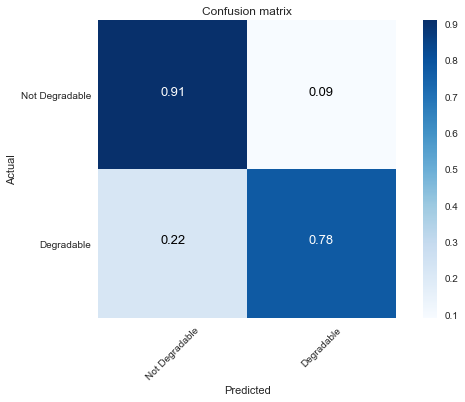

Our Accuracy is: 0.8643533123028391
Our Precision is: 0.8155339805825242
Our Sensitivity is: 0.7777777777777778
Our F-Score is: 0.7962085308056872


In [54]:
forest_base = RandomForestClassifier(n_estimators=100, random_state=42)

forest_base.fit(X_train,y_train)
forest_base_pred = forest_base.predict(X_test)

results_dict_list.append(evaluate_classifier(y_test,forest_base_pred, normalize=True));
results_model_names_list.append("RandFor_lin")

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
KNN_base = KNeighborsClassifier(n_neighbors = 13)

KNN_base.fit(X_train,y_train)
KNN_base_pred = KNN_base.predict(X_test)

results_dict_list.append(evaluate_classifier(y_test,KNN_base_pred, normalize=True));
results_model_names_list.append("KNN_lin")

### Ensemble

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

In [ ]:
clf1 = logReg_base_l1
clf2 = forest_base
clf3 = KNN_base
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('KNN', clf3)], voting='hard')
eclf.fit(X_train,y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'KNN', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
    print("F1: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [ ]:
eclf_base_pred = eclf.predict(X_test)
results_dict_list.append(evaluate_classifier(y_test,eclf_base_pred, normalize=True));
results_model_names_list.append("Ensemble_lin")

## Poly

### Logistic Regression

In [ ]:
X_train = X_train_poly.copy()
X_test = X_test_poly.copy()

In [ ]:
logReg_base_l1_poly = LogisticRegression(solver = "saga", penalty = "l1", C = 1, random_state=42)

logReg_base_l1_poly.fit(X_train_poly,y_train)
logReg_base_l1_poly_pred = logReg_base_l1_poly.predict(X_test_poly)
results_dict_list.append(evaluate_classifier(y_test,logReg_base_l1_poly_pred, normalize=True))
drop_l1_poly = plot_coefs(X_train_poly,logReg_base_l1_poly)
results_model_names_list.append("LogR_poly")

### Random Forrest

In [ ]:
forest_base = RandomForestClassifier(n_estimators=100, random_state=42)

forest_base.fit(X_train,y_train)
forest_base_pred = forest_base.predict(X_test)
results_dict_list.append(evaluate_classifier(y_test,forest_base_pred, normalize=True));
results_model_names_list.append("RandFor_poly")

In [ ]:
rfc_featimp_df = pd.DataFrame(forest_base.feature_importances_, index = X_train.columns)
sorted_rfc = rfc_featimp_df.sort_values(by = 0, ascending = False)
rfc_add = list(sorted_rfc[sorted_rfc[0]>0.01].head(3).index)
rfc_add

### KNN

In [ ]:
KNN_base = KNeighborsClassifier(n_neighbors = 13)

KNN_base.fit(X_train,y_train)
KNN_base_pred = KNN_base.predict(X_test)
results_dict_list.append(evaluate_classifier(y_test,KNN_base_pred, normalize=True));
results_model_names_list.append("KNN_poly")

### Ensemble

In [ ]:
clf1 = logReg_base_l1
clf2 = forest_base
clf3 = KNN_base
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('KNN', clf3)], voting='hard')
eclf.fit(X_train,y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'KNN', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
    print("F1: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [ ]:
eclf_base_pred = eclf.predict(X_test)
results_dict_list.append(evaluate_classifier(y_test,eclf_base_pred, normalize=True));
results_model_names_list.append("Ensemble_poly")

# Model Selection

The goal of this section is to choose the model type, that performes best on the given data. Afterwards this model will be tuned using hyperparameter tuning to further improve its performance

In [ ]:
#function for quick comparison
from functions import compare_models

In [ ]:
#use the stored performance data from the modeling section to produce a summary table
out_df = compare_models(results_dict_list, results_model_names_list )
out_df["sum"] = out_df.iloc[:,0:4].sum(axis = 1)
out_df.drop("confusion_matrix", axis = 1).applymap(lambda x: round(x,2)).sort_values(by = "sum", ascending = False)

The table schows that the logistic regression models perform the best. To get more insight, the data is plotted:

In [ ]:
out_df = out_df.sort_values(by = "sum", ascending = False)

In [ ]:
res_cols = ["accuracy","precission","sensitivity","f_1"]
for col in res_cols:
    plt.plot(out_df.index, out_df[col], label = col)
    plt.xticks(rotation=90)
    plt.legend()
plt.ylabel("Scoring")
plt.title("Model Performances", fontdict = {"fontsize": 16} )

## Result of Model Selection
Both Logistic Regression models without polynomial Features perform quite well, thus Logistic Regression is chosen for optimization

# Model Optimization

Select linear Features, that were not restricted to a coefficient of zero by lasso selection (see feature selection) and reselect training and test feature accordingly.

In [ ]:
features = list(set(l1_keep).union((lin_cols_all)))
#features

In [ ]:
X_train = X_train_poly[features]
X_test = X_test_poly[features]

## Gridsearch

Gridsearch. is used for Hyperparameter tuning of the LogisticRegression model. It also comes with a built in cross validation, that will make the models scoring matrics even more robust.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

A custom scoring is chosen to best fit all of the specified metrics. This metric is the sum of all the other metrics seen previously. I have chosen this approach, because there is not just one single metric of interes but four.

In [ ]:
def custom_scorer(y_true,y_pred):
    f1 = metrics.f1_score(y_true,y_pred)
    acc = metrics.accuracy_score(y_true,y_pred)
    prec = metrics.precision_score(y_true,y_pred)
    sens = metrics.recall_score(y_true,y_pred)
    return f1+acc+prec+sens

Initialize and run gridsearch

In [ ]:
lgR_20 = LogisticRegression(random_state = 42)

param_grid = {"solver":["liblinear","saga"],
          "penalty":["l1","l2"],
          "C":np.arange(0.1,1,0.05),
             }

In [ ]:
grid_logR = GridSearchCV(estimator = lgR_20,
                         param_grid = param_grid,
                         scoring = make_scorer(custom_scorer),
                         cv = 5,
                         verbose = 4,
                         n_jobs = -1)

In [ ]:
grid_logR.fit(X_train,y_train)

Investigating the grid search results:

In [ ]:
grid_logR.best_score_

In [ ]:
grid_logR_pred = grid_logR.best_estimator_.predict(X_test)
evaluate_classifier(grid_logR_pred,y_test, normalize=True);

The best cross validation score (3.27) is lower than the top score (3.40) achieved earlier. The reason behind this is that the cross validation performed during the grid searach will only draw from the training set splitting it into a new training and a validation set multiple times. Therefore the number of observations the model is actually trained on to be optimized is less then before. This results in a lower overall score but in a more robust scoring metric, because the model is tested multiple times oin multiple different test sets with each crossvalidation step.

In [ ]:
grid_logR.best_params_

The above parameters will be used to retrain a Logistic Regression model on the whole training set and hopefully improve its performance.

# Final Model

One last time the model is refit and evaluated

In [ ]:
lgR_2 = LogisticRegression(solver = "liblinear", penalty = "l2", C = 0.9, random_state=42)

lgR_2.fit(X_train,y_train)
lgR_2_pred = lgR_2.predict(X_test)

results_dict_list.append(evaluate_classifier(lgR_2_pred,y_test, normalize=True))

Model performance did not improve with running the Gridsearch. However, the cross validation used in the process provides a more robust model. Hence the Final model as seen above is used.

The overall model performance provides a good classification of the target `degradability`. Remember, the overall most import metric being the precision score. The obtained precision score states that using this model 85% of all compounds to be classified as `degradable` are truly degradable.

Furthermore Sensitivity (81%) and Specificity are (92%) are higher than in the original model provided in the data source (both values being at around 80%).

The nature of the logistic regression model lets us further investigate the relationship between the used features and the classification. This feature importance is shown in the next section.

## Inspect final feature importance

In [ ]:
zeros_df = plot_coefs(X_train,lgR_2,return_nulls = False);

Rank top 20 most important features and display them for visualization

In [ ]:
#compute feature ranks by absolute value of the coefficients
zeros_df["abs"] = zeros_df.coeff.apply(lambda x: abs(x))
top_20_df = zeros_df.sort_values(by = "abs", ascending = False).head(20)
top_20_df["rank"] = list(range(1,21))

top_20_df[["rank","coeff"]]

It can be seen, that among the top twenty features, the engineered feature for molecule functionality (`nHM_heavy` and `nHM_functional`) are present whereas the original feature `nHM` it was derived from is not.

Save Model

In [ ]:
import pickle
#with open("lgR_model_save.pickle" ,"wb") as f:
    #pickle.dump(lgR_2,f) 

# Conclusions

In this Project multiple ways of using QSAR data to classify bio degradable compounds are investigated. The following models have been tested:
 + logistic regression
 + KNN
 + random forest
 + an ensemble classifier of all the above

I conclude that the best type of model for this problem is a logistic regression model.
The <a href="#Final-Model" data-toc-modified-id="Final-Model-10">final model</a> has a accuracy of 88%. It out performs the researchers model that provided the dataset. 
There is evidence that this improvement in performance on this classification task is due to the <a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5"> engineered feature</a> of "molecule functionality".

Due to the highly interpretable nature of the Linear Regression <a href="#Inspect-final-feature-importance" data-toc-modified-id="Inspect-final-feature-importance-10.1">coefficients</a> the following molecular features should be considered for developing new biodegradable compounds:
+ include a high number of oxygen atoms
+ while maintaining a high percentage of carbon atoms
+ which should not be sp4 hybridized (be of type ssssC)
+ and not be part of (substituted) benzenes

Thus, provinding unsaturated basic hydrocarbons with (polar) oxygen based functional groups would be a good base to start with.